In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import time
from spn_3.spn import SPN
from utils import train, count_parameters, apply_lth_pruning, clean_weights, merge_weights


In [2]:
# Set the seed for PyTorch (CPU and GPU)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
#hyperparameters
batch_size = 256
learning_rate = 1e-3
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Get Dataset

In [4]:
#Download the dataset (OpenML: id 180)
dataset = openml.datasets.get_dataset(180)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

In [5]:
X_numeric = X.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric.values.astype(np.float32))

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts to 0...6
y_encoded = y_encoded.astype(np.int64)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [7]:
class CovertypeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = CovertypeDataset(X_train, y_train)
test_ds = CovertypeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Minimal MLP

In [8]:
class Minimal_MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

MLP baseline

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_dims, num_classes):
        super().__init__()
        layers = []
        prev_dim = input_size
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [10]:
num_classes = len(le.classes_)
MLP_hidden_dims = [128, 64]
total_nodes = sum(MLP_hidden_dims)
input_size = X_train.shape[1]
num_samples = X_train.shape[0]

In [11]:
model_0 = Minimal_MLP(input_size, sum(MLP_hidden_dims), num_classes).cuda()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)

In [13]:
param_count_0 = count_parameters(model_0)

In [14]:
train_metrics_0, val_metrics_0 = train(model_0, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.2712 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.6315 Train_Loss: 1.0103 Validation_Accuracy: 0.6738 Validation_Loss: 0.8779
Epoch: 2 Total_Time: 0.2655 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.6793 Train_Loss: 0.8729 Validation_Accuracy: 0.6878 Validation_Loss: 0.8437
Epoch: 3 Total_Time: 0.2658 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.6871 Train_Loss: 0.8515 Validation_Accuracy: 0.6907 Validation_Loss: 0.8287
Epoch: 4 Total_Time: 0.2481 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.6928 Train_Loss: 0.8379 Validation_Accuracy: 0.6989 Validation_Loss: 0.8147
Epoch: 5 Total_Time: 0.2583 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.6978 Train_Loss: 0.8265 Validation_Accuracy: 0.7029 Validation_Loss: 0.8048
Epoch: 6 Total_Time: 0.2590 Average_Time_per_batch: 0.0008 Train_Accuracy: 0.7021 Train_Loss: 0.8171 Validation_Accuracy: 0.7083 Validation_Loss: 0.7954
Epoch: 7 Total_Time: 0.2548 Average_Time_per_batch: 0.0007 Train_Accuracy: 0.7061

In [15]:
model_1 = MLP(input_size, MLP_hidden_dims, num_classes).to(device)

In [16]:
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

In [17]:
param_count_1 = count_parameters(model_1)

In [18]:
train_metrics_1, val_metrics_1 = train(model_1, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.4482 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.6476 Train_Loss: 0.9797 Validation_Accuracy: 0.6824 Validation_Loss: 0.8557
Epoch: 2 Total_Time: 0.4463 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.6864 Train_Loss: 0.8510 Validation_Accuracy: 0.6936 Validation_Loss: 0.8185
Epoch: 3 Total_Time: 0.4475 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.6975 Train_Loss: 0.8262 Validation_Accuracy: 0.7025 Validation_Loss: 0.8034
Epoch: 4 Total_Time: 0.4354 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.7040 Train_Loss: 0.8104 Validation_Accuracy: 0.7081 Validation_Loss: 0.7895
Epoch: 5 Total_Time: 0.4479 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.7105 Train_Loss: 0.7960 Validation_Accuracy: 0.7151 Validation_Loss: 0.7758
Epoch: 6 Total_Time: 0.4461 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.7164 Train_Loss: 0.7846 Validation_Accuracy: 0.7189 Validation_Loss: 0.7661
Epoch: 7 Total_Time: 0.4414 Average_Time_per_batch: 0.0013 Train_Accuracy: 0.7208

Minimal SPN

In [19]:
model_2 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes).cuda()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [20]:
param_count_2 = model_2.count_parameters()

In [21]:
train_metrics_2, val_metrics_2 = train(model_2, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.3446 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.6341 Train_Loss: 1.0057 Validation_Accuracy: 0.6764 Validation_Loss: 0.8764
Epoch: 2 Total_Time: 0.3426 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.6796 Train_Loss: 0.8704 Validation_Accuracy: 0.6909 Validation_Loss: 0.8422
Epoch: 3 Total_Time: 0.3443 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.6893 Train_Loss: 0.8466 Validation_Accuracy: 0.6946 Validation_Loss: 0.8238
Epoch: 4 Total_Time: 0.3464 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.6954 Train_Loss: 0.8330 Validation_Accuracy: 0.6995 Validation_Loss: 0.8112
Epoch: 5 Total_Time: 0.3434 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.6989 Train_Loss: 0.8222 Validation_Accuracy: 0.7055 Validation_Loss: 0.8011
Epoch: 6 Total_Time: 0.3445 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.7037 Train_Loss: 0.8148 Validation_Accuracy: 0.7044 Validation_Loss: 0.7963
Epoch: 7 Total_Time: 0.3413 Average_Time_per_batch: 0.0010 Train_Accuracy: 0.7068

Maximal SPN

In [22]:
model_3 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [23]:
param_count_3 = model_3.count_parameters()

In [24]:
train_metrics_3, val_metrics_3 = train(model_3, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 21.0974 Average_Time_per_batch: 0.0612 Train_Accuracy: 0.6598 Train_Loss: 0.9438 Validation_Accuracy: 0.6879 Validation_Loss: 0.8281
Epoch: 2 Total_Time: 21.0496 Average_Time_per_batch: 0.0610 Train_Accuracy: 0.6905 Train_Loss: 0.8318 Validation_Accuracy: 0.6950 Validation_Loss: 0.8092
Epoch: 3 Total_Time: 21.0587 Average_Time_per_batch: 0.0610 Train_Accuracy: 0.6990 Train_Loss: 0.8121 Validation_Accuracy: 0.7079 Validation_Loss: 0.7860
Epoch: 4 Total_Time: 21.0149 Average_Time_per_batch: 0.0609 Train_Accuracy: 0.7055 Train_Loss: 0.7946 Validation_Accuracy: 0.7173 Validation_Loss: 0.7711
Epoch: 5 Total_Time: 21.0125 Average_Time_per_batch: 0.0609 Train_Accuracy: 0.7154 Train_Loss: 0.7769 Validation_Accuracy: 0.7278 Validation_Loss: 0.7513
Epoch: 6 Total_Time: 19.2450 Average_Time_per_batch: 0.0558 Train_Accuracy: 0.7267 Train_Loss: 0.7577 Validation_Accuracy: 0.7346 Validation_Loss: 0.7383
Epoch: 7 Total_Time: 21.0366 Average_Time_per_batch: 0.0610 Train_Accuracy:

Free Weights SPN

In [25]:
model_4 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False, hidden_dims = MLP_hidden_dims + [num_classes]).cuda()
optimizer = optim.Adam(model_4.parameters(), lr=learning_rate)

In [26]:
param_count_4 = model_4.count_parameters()

In [27]:
train_metrics_4, val_metrics_4 = train(model_4, train_loader, test_loader, epochs, optimizer, criterion, device=device)


Epoch: 1 Total_Time: 0.5643 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.6533 Train_Loss: 0.9620 Validation_Accuracy: 0.6868 Validation_Loss: 0.8359
Epoch: 2 Total_Time: 0.5630 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.6886 Train_Loss: 0.8397 Validation_Accuracy: 0.6969 Validation_Loss: 0.8144
Epoch: 3 Total_Time: 0.5632 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.6957 Train_Loss: 0.8239 Validation_Accuracy: 0.7020 Validation_Loss: 0.8009
Epoch: 4 Total_Time: 0.5553 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.7016 Train_Loss: 0.8109 Validation_Accuracy: 0.7061 Validation_Loss: 0.7939
Epoch: 5 Total_Time: 0.5578 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.7079 Train_Loss: 0.7986 Validation_Accuracy: 0.7145 Validation_Loss: 0.7775
Epoch: 6 Total_Time: 0.5613 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.7122 Train_Loss: 0.7888 Validation_Accuracy: 0.7186 Validation_Loss: 0.7681
Epoch: 7 Total_Time: 0.5567 Average_Time_per_batch: 0.0016 Train_Accuracy: 0.7168

Maximal SPN with pruning

In [28]:
model_5 = SPN(input_size, sum(MLP_hidden_dims) + num_classes, num_classes, minimal=False).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [29]:
percent = 0.99
rounds = 10
pruning_epochs = 3

pruning_start = time.time()
new_weights = apply_lth_pruning(model_5, train_loader, test_loader, pruning_epochs, optimizer, criterion, percent, rounds)
pruning_time = time.time() - pruning_start

Initial Validation Phase
Epoch: 1 Total_Time: 21.2342 Average_Time_per_batch: 0.0615 Train_Accuracy: 0.6577 Train_Loss: 0.9471 Validation_Accuracy: 0.6893 Validation_Loss: 0.8281
Epoch: 2 Total_Time: 21.2155 Average_Time_per_batch: 0.0615 Train_Accuracy: 0.6914 Train_Loss: 0.8327 Validation_Accuracy: 0.6970 Validation_Loss: 0.8082
Epoch: 3 Total_Time: 21.0353 Average_Time_per_batch: 0.0610 Train_Accuracy: 0.6990 Train_Loss: 0.8127 Validation_Accuracy: 0.7043 Validation_Loss: 0.7880

Pruning Round: 1
Epoch: 1 Total_Time: 20.9863 Average_Time_per_batch: 0.0608 Train_Accuracy: 0.6688 Train_Loss: 0.9145 Validation_Accuracy: 0.6858 Validation_Loss: 0.8280
Epoch: 2 Total_Time: 21.0020 Average_Time_per_batch: 0.0609 Train_Accuracy: 0.6917 Train_Loss: 0.8290 Validation_Accuracy: 0.7006 Validation_Loss: 0.8021
Epoch: 3 Total_Time: 20.9847 Average_Time_per_batch: 0.0608 Train_Accuracy: 0.6994 Train_Loss: 0.8104 Validation_Accuracy: 0.7090 Validation_Loss: 0.7821

Pruning Round: 2
Epoch: 1 Total_

In [30]:
cleaned_weights = clean_weights(new_weights, input_size)
merged_weights = merge_weights(cleaned_weights, input_size, num_classes)

Empty Blocks:  []


In [31]:
hidden_dims_pruned = [weight.shape[0] for weight in merged_weights]
print("Pruned Dimensions: ", hidden_dims_pruned)
print("Pruning Time: ", pruning_time)

Pruned Dimensions:  [1, 2, 2, 4, 2, 3, 3, 5, 2, 2, 3, 1, 2, 4, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 1, 1, 2, 1, 2, 4, 3, 1, 1, 4, 1, 2, 3, 1, 3, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 1, 3, 2, 2, 1, 1, 3, 1, 1, 1, 1, 3, 2, 5, 2, 3, 2, 2, 2, 3, 2, 1, 3, 2, 1, 2, 2, 3, 2, 1, 2, 1, 3, 1, 2, 4, 1]
Pruning Time:  280.33404660224915


In [32]:
model_5 = SPN(input_size, sum(hidden_dims_pruned), num_classes, minimal=False, hidden_dims=hidden_dims_pruned).cuda()
optimizer = optim.Adam(model_5.parameters(), lr=learning_rate)

In [33]:
param_count_5 = model_5.count_parameters()

In [34]:
train_metrics_5, val_metrics_5 = train(model_5, train_loader, test_loader, epochs, optimizer, criterion)


Epoch: 1 Total_Time: 15.3742 Average_Time_per_batch: 0.0446 Train_Accuracy: 0.6586 Train_Loss: 0.9439 Validation_Accuracy: 0.6886 Validation_Loss: 0.8308
Epoch: 2 Total_Time: 15.1710 Average_Time_per_batch: 0.0440 Train_Accuracy: 0.6887 Train_Loss: 0.8363 Validation_Accuracy: 0.7003 Validation_Loss: 0.8066
Epoch: 3 Total_Time: 15.2354 Average_Time_per_batch: 0.0442 Train_Accuracy: 0.6973 Train_Loss: 0.8158 Validation_Accuracy: 0.7022 Validation_Loss: 0.7929
Epoch: 4 Total_Time: 15.3922 Average_Time_per_batch: 0.0446 Train_Accuracy: 0.7028 Train_Loss: 0.7996 Validation_Accuracy: 0.7141 Validation_Loss: 0.7726
Epoch: 5 Total_Time: 15.2358 Average_Time_per_batch: 0.0442 Train_Accuracy: 0.7129 Train_Loss: 0.7780 Validation_Accuracy: 0.7221 Validation_Loss: 0.7553
Epoch: 6 Total_Time: 15.2393 Average_Time_per_batch: 0.0442 Train_Accuracy: 0.7250 Train_Loss: 0.7574 Validation_Accuracy: 0.7343 Validation_Loss: 0.7383
Epoch: 7 Total_Time: 15.2806 Average_Time_per_batch: 0.0443 Train_Accuracy:

Plot Training and Test Accuracies Across Epochs

In [35]:
import matplotlib.pyplot as plt

train_acc_0 = train_metrics_0[:, 2] / (num_samples / batch_size)
train_acc_1 = train_metrics_1[:, 2] / (num_samples / batch_size)
train_acc_2 = train_metrics_2[:, 2] / (num_samples / batch_size)
train_acc_3 = train_metrics_3[:, 2] / (num_samples / batch_size)
train_acc_4 = train_metrics_4[:, 2] / (num_samples / batch_size)
train_acc_5 = train_metrics_5[:, 2] / (num_samples / batch_size)

epochs = np.arange(1, epochs + 1)

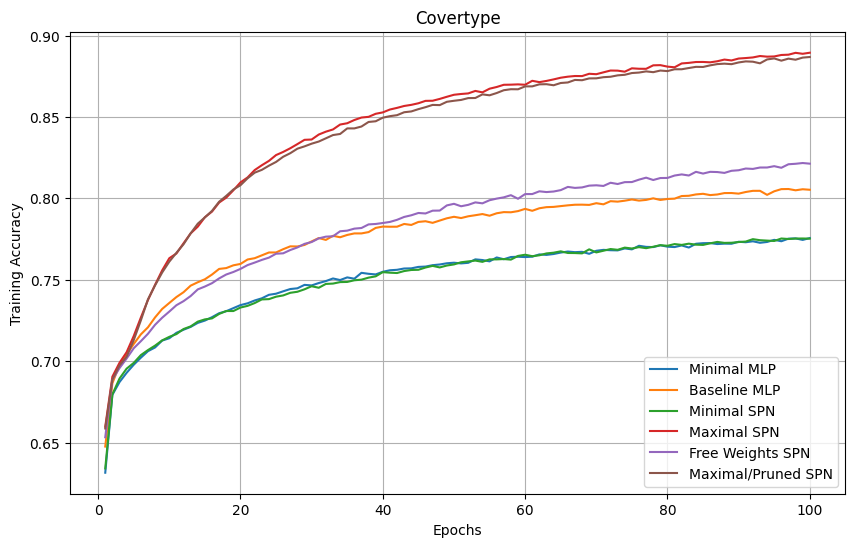

In [36]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_acc_0, label='Minimal MLP')
plt.plot(epochs, train_acc_1, label='Baseline MLP')
plt.plot(epochs, train_acc_2, label='Minimal SPN')
plt.plot(epochs, train_acc_3, label='Maximal SPN')
plt.plot(epochs, train_acc_4, label='Free Weights SPN')
plt.plot(epochs, train_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Covertype')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Covertype/training_accuracy_plot.png')  # Save as PNG file
plt.show()

In [37]:
test_acc_0 = val_metrics_0[:, 1]
test_acc_1 = val_metrics_1[:, 1]
test_acc_2 = val_metrics_2[:, 1]
test_acc_3 = val_metrics_3[:, 1]
test_acc_4 = val_metrics_4[:, 1]
test_acc_5 = val_metrics_5[:, 1]

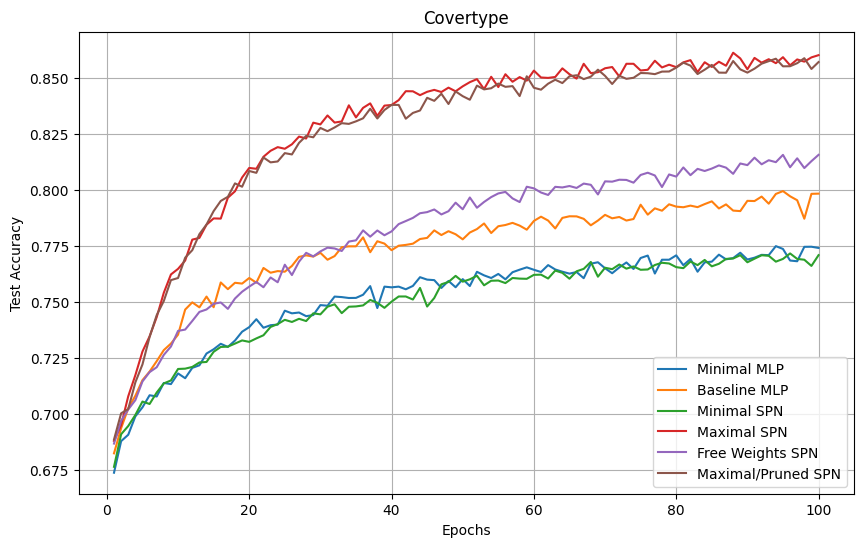

In [38]:
# Plot the training accuracy of all 5 models
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_acc_0, label='Minimal MLP')
plt.plot(epochs, test_acc_1, label='Baseline MLP')
plt.plot(epochs, test_acc_2, label='Minimal SPN')
plt.plot(epochs, test_acc_3, label='Maximal SPN')
plt.plot(epochs, test_acc_4, label='Free Weights SPN')
plt.plot(epochs, test_acc_5, label='Maximal/Pruned SPN')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Covertype')

# Adding a legend to distinguish the models
plt.legend()

# Show the plot
plt.grid(True)

#save the plot
plt.savefig('results/Covertype/test_accuracy_plot.png')  # Save as PNG file
plt.show()

Get efficiency of each model

In [39]:
# List of all test accuracies
test_accuracies = [test_acc_0, test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

# Find the index of the best (maximum) accuracy for each model
best_accuracy_indices = [np.argmax(acc) + 1 for acc in test_accuracies]

In [40]:
time_to_best_acc_0 = train_metrics_0[:best_accuracy_indices[0], 0].sum()
time_to_best_acc_1 = train_metrics_1[:best_accuracy_indices[1], 0].sum()
time_to_best_acc_2 = train_metrics_2[:best_accuracy_indices[2], 0].sum()
time_to_best_acc_3 = train_metrics_3[:best_accuracy_indices[3], 0].sum()
time_to_best_acc_4 = train_metrics_4[:best_accuracy_indices[4], 0].sum()
time_to_best_acc_5 = train_metrics_5[:best_accuracy_indices[5], 0].sum()

best_test_acc_0 = test_acc_0[best_accuracy_indices[0] - 1]
best_test_acc_1 = test_acc_1[best_accuracy_indices[1] - 1]
best_test_acc_2 = test_acc_2[best_accuracy_indices[2] - 1]
best_test_acc_3 = test_acc_3[best_accuracy_indices[3] - 1]
best_test_acc_4 = test_acc_4[best_accuracy_indices[4] - 1]
best_test_acc_5 = test_acc_5[best_accuracy_indices[5] - 1]

In [41]:
summary_0 = ['Minimal MLP', param_count_0, best_test_acc_0, time_to_best_acc_0, best_test_acc_0 / time_to_best_acc_0]
summary_1 = ['Baseline MLP', param_count_1, best_test_acc_1, time_to_best_acc_1, best_test_acc_1 / time_to_best_acc_1]
summary_2 = ['Minimal SPN', param_count_2, best_test_acc_2, time_to_best_acc_2, best_test_acc_2 / time_to_best_acc_2]
summary_3 = ['Maximal SPN', param_count_3, best_test_acc_3, time_to_best_acc_3, best_test_acc_3 / time_to_best_acc_3]
summary_4 = ['Free Weights SPN', param_count_4, best_test_acc_4, time_to_best_acc_4, best_test_acc_4 / time_to_best_acc_4]
summary_5 = ['Maximal/Pruned SPN', param_count_5, best_test_acc_5, time_to_best_acc_5, best_test_acc_5 / time_to_best_acc_5]

In [42]:
import pandas as pd

# Combine all summaries into a list of lists (each summary as a row)
summaries = [summary_0, summary_1, summary_2, summary_3, summary_4, summary_5]

# Create a DataFrame
df = pd.DataFrame(summaries, columns=['Model', 'Parameter Count', 'Best Test Accuracy', 'Time to Best Test Accuracy', 'Efficiency'])

# Set the display options to allow for better fitting
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width so it can fit more columns
pd.set_option('display.max_colwidth', None)  # Allow unlimited column width

# Now when you print the DataFrame, it will be displayed as a continuous table
print(df)

                Model  Parameter Count  Best Test Accuracy  Time to Best Test Accuracy  Efficiency
0         Minimal MLP             4231            0.774854                   30.273395    0.025595
1        Baseline MLP            10631            0.799402                   42.193961    0.018946
2         Minimal SPN             4329            0.771593                   33.286283    0.023181
3         Maximal SPN            22686            0.861135                 1850.016092    0.000465
4    Free Weights SPN            12521            0.815571                   53.472362    0.015252
5  Maximal/Pruned SPN            22543            0.858689                 1494.627587    0.000575


In [43]:
df.to_csv('results/Covertype/model_summary.csv', index=False)